In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import json

In [2]:
train = pd.read_csv('preprocessed.csv')

I preprocessed data in 'preprocessed' notebook.

In [3]:
train['is_duplicate'].mean()

0.36919785302629299

Luckily, class imbalance is not as large as in, for instance, fraud detection

In [4]:
train.ix[0, ['question1', 'question2']].tolist()

['what is the step by step guide to invest in share market in india ?',
 'what is the step by step guide to invest in share market ?']

These are not duplicates - so this is going to be hard problem to crack, since Tf-Idf or any counting methods can have a hard time. First things first, let's investigate how proportion of common words correlates with being duplicate. Then I will go into checking n-grams.

In [5]:
def count_common_ngrams(row, n_gram=1):
    #just in case i will ever use different dataframes
    
    N = data.shape[0]
    counts = []
    
    for i in range(N):
        
        ques = list(map(lambda x: x.split(), data.ix[i, ['question1', 'question2']].tolist()))
        
        first = [' '.join(ques[0][j:j+n_gram]) for j in range(len(ques[0]) - n_gram +1)]
        second = [' '.join(ques[1][j:j+n_gram]) for j in range(len(ques[1])- n_gram +1)]
        
        sfirst = set(first)
        ssecond = set(second)
        common = sfirst & ssecond
        
        counts.append([len(common), len(first), len(second), len(sfirst), len(ssecond)])
        
    return counts

In [6]:
def get_proportions(arr, agg=max):
    
    ag1 = agg(arr[1:3])
    ag2 = agg(arr[3:])
    z = []
    if ag1 == 0:
        z.append(0)
    else:
        z.append(arr[0]/ag1)
        
    if ag2 == 0:
        z.append(0)
    else:
        z.append(arr[0]/ag2)
        
    z.append( abs( arr[3] - arr[4] ) )
    z.append( abs( arr[1] - arr[2] ) )
        
    return z

In [7]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from functools import partial

In [8]:
class NgramVectorizer:
    
    def __init__(self, ngram=1, agg='min'):
        
        self.n = ngram
        if isinstance(self.n, int):
            self.n = [self.n]
        pot = {'min':min, 'max':max, 'mean':np.mean, 'sum':sum}
        self.prop = partial(get_proportions, agg=pot[agg])
        
    def translate(self, data):
        
        return np.hstack([np.asarray(list(map(self.prop, count_common_ngrams(data, n)))) for n in self.n])
        
        
    def fit(self, X, y=None):
        
        self.data = self.translate(X)
    
        return self
    
    def transform(self, X):
        
        return self.translate(X)
    
    def fit_transform(self, X, y=None):
        
        self.data = self.translate(X)
        return self.data

In [9]:
ngrams = NgramVectorizer(ngram=[1,2,3,4])

In [10]:
st = list(set(list(map(type, train['question2']))))[0]

In [11]:
prop = np.where(train['question2'].apply(lambda x: type(x) == st))

In [12]:
train = train.ix[prop]

In [13]:
train = train.reset_index()

In [14]:
ngrams.fit(train[:10000])

In [15]:
def plot_histograms(data, y, bins=10):
    
    y = np.asarray(y.tolist())
    
    ones = np.where(y==1)[0]
    zeros = np.where(y==0)[0]
    
    
    plt.hist(data[ones], color='r', alpha=.5, bins=bins, label='duplicate')
    plt.hist(data[zeros], color='b', alpha=.5, bins=bins, label='not duplicate')
    plt.legend(loc='best')

In [16]:
def plot_boxes(data, y):
    
    y = np.asarray(y.tolist())
    
    ones = np.where(y==1)[0]
    zeros = np.where(y==0)[0]
    
    dataset = [data[ones], data[zeros]]
    
    plt.boxplot(dataset)
    plt.xticks(range(1,3), ['duplicates', 'not duplicates'], rotation=45)

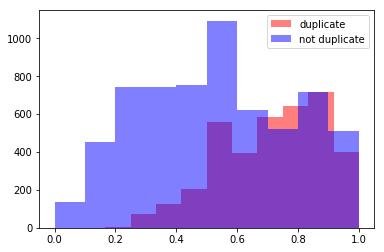

In [17]:
plot_histograms(ngrams.data[:, 0], train.ix[:int(1e4)-1, 'is_duplicate'])
plt.show()

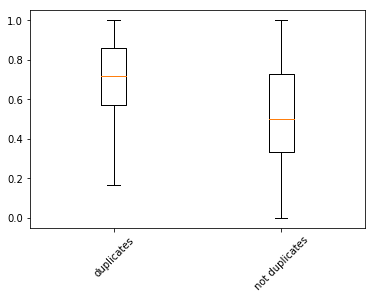

In [18]:
plot_boxes(ngrams.data[:, 0], train.ix[:int(1e4)-1, 'is_duplicate'])
plt.show()

In [19]:
y_sample = train.ix[:int(1e4)-1, 'is_duplicate']

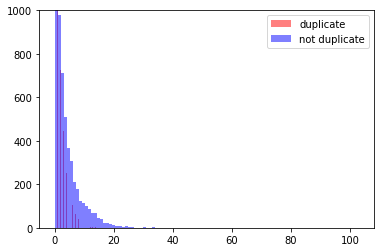

In [20]:
plot_histograms(ngrams.data[:, 2], y_sample, bins=100)
plt.ylim(0, 1000)
plt.show()

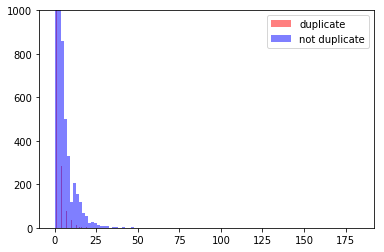

In [21]:
plot_histograms(ngrams.data[:, 6], y_sample, bins=100)
plt.ylim(0, 1000)
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(ngrams.data, y_sample.tolist(), test_size=.3)

In [24]:
lr = LogisticRegression(C=5)
lr.fit(x_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
def get_scores(clf, x_test, y_test):
    
    return {
        'log loss': log_loss(y_test, clf.predict_proba(x_test)),
        'accuracy': clf.score(x_test, y_test),
        'precision': precision_score(clf.predict(x_test), y_test),
        'recall': recall_score(clf.predict(x_test), y_test),
        'roc auc': roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])
    }

In [26]:
from sklearn.metrics import precision_score, recall_score, log_loss, roc_auc_score

In [27]:
get_scores(lr, x_test, y_test)

{'accuracy': 0.67000000000000004,
 'log loss': 0.56151973348446771,
 'precision': 0.45362718089990817,
 'recall': 0.55568053993250843,
 'roc auc': 0.73934603155382383}

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
def is_subset(row):
    
    words_1 = set(row['question1'].lower().split())
    words_2 = set(row['question2'].lower().split())
    
    if len(words_1) - len(words_2) == len(words_1 - words_2):
        
        return 1
    
    elif len(words_2) - len(words_1) == len(words_2 - words_1):
        
        return -1
    
    else:
        
        return 0

In [30]:
subsets = train.apply(is_subset, axis=1)

In [31]:
subsets.value_counts()

 0    375706
 1     16548
-1     12034
dtype: int64

In [32]:
subsets[train['is_duplicate']==1].value_counts()

 0    132354
 1      9290
-1      7619
dtype: int64

In [33]:
subsets[train['is_duplicate']==0].value_counts()

 0    243352
 1      7258
-1      4415
dtype: int64

In [34]:
x_train, x_test, y_train, y_test = train_test_split(np.hstack([ngrams.data, subsets[:len(y_sample)].as_matrix().reshape(-1, 1)]), y_sample, test_size=.3)

In [35]:
lr = LogisticRegression(C=5)
lr.fit(x_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
get_scores(lr, x_test, y_test)

{'accuracy': 0.67000000000000004,
 'log loss': 0.56536429664020682,
 'precision': 0.46528403967538323,
 'recall': 0.56516976998904711,
 'roc auc': 0.73572315161895929}

In [37]:
words = ' '.join(pd.concat([train['question1'], train['question2']], axis=0).tolist()).split()

In [38]:
from collections import defaultdict

In [39]:
word_counts = defaultdict(int)

for word in words:
    
    word_counts[word] += 1

In [40]:
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

[('?', 760365),
 ('the', 377516),
 ('what', 324523),
 ('is', 269782),
 ('i', 224138),
 ('how', 220859),
 ('a', 212880),
 ('to', 205706),
 ('in', 197232),
 ('do', 161031)]

In [41]:
sorted(word_counts.items(), key=lambda x: x[1])[:10]

[('wizardry', 1),
 ('much..', 1),
 ('collaberatact', 1),
 ('newham', 1),
 ('izumitate', 1),
 ('incredulous', 1),
 ('socialist"?', 1),
 ('blvd', 1),
 ('grefide', 1),
 ('reflexology', 1)]

In [42]:
len(word_counts)

88638

In [43]:
def gather_overall_ngram_counts(sentences, ngram_max=1):
    
    overall_count = defaultdict(int)
    document_count = defaultdict(int)
    
    for sent in sentences:
        sent = sent.split()
        for n_gram in range(1, ngram_max+1):
            ngrams = ['_'.join(sent[j:j+n_gram]) for j in range(len(sent) - n_gram +1)]

            for ngram in ngrams:

                overall_count[ngram] += 1

            for ngram in set(ngrams):

                document_count[ngram] += 1
            
    return overall_count, document_count

In [44]:
overall_count, document_count = gather_overall_ngram_counts(pd.concat([train['question1'], train['question2']], axis=0).tolist(),
                                                           ngram_max=2)

In [45]:
sorted(overall_count.items(), reverse=True, key=lambda x: x[1])

[('?', 760365),
 ('the', 377516),
 ('what', 324523),
 ('is', 269782),
 ('i', 224138),
 ('how', 220859),
 ('a', 212880),
 ('to', 205706),
 ('in', 197232),
 ('do', 161031),
 ('of', 159768),
 ('are', 145865),
 ('and', 133817),
 ('can', 118014),
 ('what_is', 117493),
 ('for', 104462),
 ('is_the', 102540),
 ('what_are', 93498),
 ('you', 92849),
 ('why', 84049),
 ('how_do', 79229),
 ('my', 70961),
 ('it', 70953),
 ('best', 70558),
 ('can_i', 62874),
 ('the_best', 61349),
 ('on', 60739),
 ('do_i', 59252),
 ('does', 56362),
 ('are_the', 55264),
 ('how_can', 55055),
 ('s', 48336),
 ('or', 44731),
 ('which', 43964),
 ('be', 43805),
 ('if', 43784),
 ('some', 41682),
 ('have', 40874),
 ('that', 40638),
 ('with', 39705),
 ('get', 39533),
 ('should', 39031),
 ('an', 37072),
 ('from', 35244),
 ('are_some', 34236),
 ('your', 33935),
 ('do_you', 30359),
 ('india', 29408),
 ('will', 28226),
 ('is_it', 27265),
 ('in_the', 26966),
 ('people', 26369),
 ('when', 26208),
 ('who', 26092),
 ('like', 25638),
 (

In [46]:
i = 0
diffs = 0
how_diff = []
for k in overall_count.keys():
    
    diffs += int(overall_count[k] != document_count[k])
    if int(overall_count[k] != document_count[k]):
        how_diff.append(int(overall_count[k] - document_count[k]))
    
    

In [47]:
vect = TfidfVectorizer(max_features=1024, ngram_range=(1,3))
vect.fit(pd.concat([train['question1'], train['question2']], axis=0).tolist())

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1024, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [48]:
type(train)

pandas.core.frame.DataFrame

In [49]:
def get_tfidf_match(row, vect=vect):
    
    q1 = vect.transform([row['question1']])
    q2 = vect.transform([row['question2']])
    
    nonzero1 = set(q1.nonzero()[1])
    nonzero2 = set(q2.nonzero()[1])
    
    numerator = q1[0, list(nonzero1&nonzero2)].sum()
    denominator = q1[0, list(nonzero1&nonzero2)].sum() + q2[0, list(nonzero2-nonzero1)].sum() + q1[0, list(nonzero1-nonzero2)].sum()
    if denominator:
        return numerator/denominator
    else:
        return 0

In [50]:
get_tfidf_match(train.ix[3])

0.0

In [51]:
from sklearn.base import TransformerMixin

In [52]:
class TfidfMatchScore(TransformerMixin):
    
    def __init__(self, vect, **kwargs):
        self.vect = vect
        self.matcher = partial(get_tfidf_match, vect=self.vect)

    def fit(X, y=None):
        assert isinstance(X, type(train))
        
        self.vect.fit(pd.concat([X['question1'], X['question2']], axis=0).tolist())
        return self
    
    def fit_transform(X, y=None):
        
        self.fit(X, y)
        return [self.matcher(X.ix[i]) for i in range(N)]
    
    def transform(self,X):
        N = X.shape[0]
        return [self.matcher(X.ix[i]) for i in range(N)]

In [53]:
matcher = TfidfMatchScore(vect=vect)

In [54]:
tfidf_scores = matcher.transform(train[:len(y_sample)])

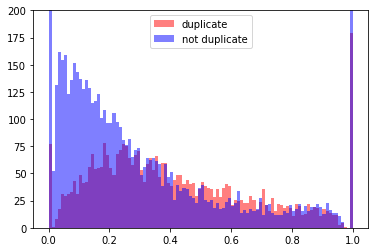

In [55]:
plot_histograms(np.asarray(tfidf_scores), y_sample, bins=100)
plt.ylim(0, 200)
plt.show()

In [56]:
unioned_train = np.concatenate([ngrams.data, subsets[:len(y_sample)].as_matrix().reshape(-1,1), np.expand_dims(np.asarray(tfidf_scores), axis=1)], axis=1)

In [57]:
x_train, x_test, y_train, y_test = train_test_split(unioned_train, np.asarray(y_sample), test_size=.3)

In [58]:
lr = LogisticRegression(C=5)
lr.fit(x_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
get_scores(lr, x_test, y_test)

{'accuracy': 0.67433333333333334,
 'log loss': 0.56620378423778428,
 'precision': 0.4642857142857143,
 'recall': 0.57971014492753625,
 'roc auc': 0.73872482902735559}

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [62]:
get_scores(rfc, x_test, y_test)

{'accuracy': 0.65933333333333333,
 'log loss': 1.6505466181808222,
 'precision': 0.47053571428571428,
 'recall': 0.55125523012552302,
 'roc auc': 0.71563972264437681}

In [63]:
for c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + list(range(1,10)):
    
    lr = LogisticRegression(C=c)
    lr.fit(x_train, y_train)
    print(get_scores(lr, x_test, y_test)['log loss'])

0.638891920385
0.633565747561
0.624499195119
0.594500921707
0.568811949979
0.566494636179
0.566364632754
0.566319374629
0.566240257408
0.566203784238
0.56617788386
0.566162665119
0.566149396989
0.566137282808


In [64]:
from sklearn.feature_extraction.text import CountVectorizer

In [65]:
BinaryVectorizer = partial(CountVectorizer, binary=True)

In [66]:
count_vect = CountVectorizer(max_features=1024, ngram_range=(1,3))

In [67]:
count_vect.fit(pd.concat([train['question1'], train['question2']], axis=0).tolist())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1024, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [68]:
bin_vect = BinaryVectorizer(max_features=1024, ngram_range=(1,3))
bin_vect.fit(pd.concat([train['question1'], train['question2']], axis=0).tolist())

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1024, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [69]:
from sklearn.pipeline import make_union

In [70]:
count_matcher = TfidfMatchScore(vect=count_vect).transform(train[:len(y_sample)])

In [71]:
bin_macher = TfidfMatchScore(vect=bin_vect).transform(train[:len(y_sample)])

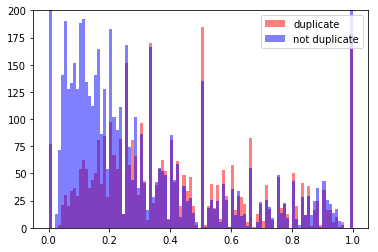

In [72]:
plot_histograms(np.asarray(count_matcher), y_sample, bins=100)
plt.ylim(0, 200)
plt.show()

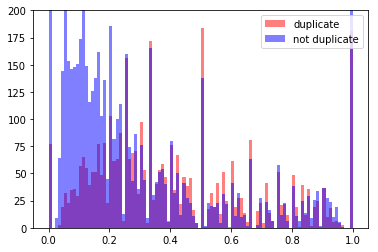

In [73]:
plot_histograms(np.asarray(bin_macher), y_sample, bins=100)
plt.ylim(0, 200)
plt.show()

In [74]:
def merge_features(*args):
    
    return np.concatenate([x if isinstance(x, np.ndarray) else np.asarray(x).reshape(-1,1) for x in args], axis=1)

In [75]:
unioned = merge_features(unioned_train, count_matcher, bin_macher)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(unioned, np.asarray(y_sample), test_size=.3)

In [77]:
lr = LogisticRegression(C=5)
lr.fit(x_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
get_scores(lr, x_test, y_test)

{'accuracy': 0.69033333333333335,
 'log loss': 0.54869318805046141,
 'precision': 0.47925860547219773,
 'recall': 0.61564625850340138,
 'roc auc': 0.76518228288889911}

In [79]:
from sklearn.model_selection import cross_val_score

In [80]:
cross_val_score(lr, unioned_train, np.asarray(y_sample), cv=10, scoring='neg_log_loss').mean()

-0.55832666752142768

In [81]:
from sklearn.preprocessing import PolynomialFeatures, scale

In [82]:
poly = PolynomialFeatures(interaction_only=True, degree=3)

In [83]:
poly_unioned_train = poly.fit_transform(unioned_train)

In [84]:
poly_scaled = (poly_unioned_train - np.mean(poly_unioned_train, axis=0))/(1e-3 + np.std(poly_unioned_train, axis=0))

In [85]:
cross_val_score(lr, poly_scaled, np.asarray(y_sample), cv=10, scoring='neg_log_loss')

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


array([-0.54325635, -0.51363053, -0.56636263, -0.54817699, -0.54054396,
       -0.55133238, -0.53247539, -0.54956418, -0.53279873, -0.53863569])

In [86]:
from sklearn.neural_network import MLPClassifier

In [87]:
import hyperopt
from hyperopt import fmin, Trials, tpe, STATUS_OK, hp

In [88]:
mlp = MLPClassifier()
cross_val_score(mlp, unioned_train, np.asarray(y_sample), cv=10, scoring='neg_log_loss').mean()

-0.54676884473179244

In [89]:
mlp = MLPClassifier()
cross_val_score(mlp, unioned, np.asarray(y_sample), cv=10, scoring='neg_log_loss').mean()

-0.53694268949716595

In [90]:
space4rfc = {
    'n_estimators': hp.choice('n_estimators', range(10,50)),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', [None] + list(range(10, 30))),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'min_samples_split': hp.choice('min_samples_split', range(2,5)),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', [None] + list(range(10, 30)))
}

#disclaimer - I know absolutely nothing about optimizing random forests, so these values are pulled straight from 
#my baseball cap

def objective(params):
    
    rfc = RandomForestClassifier(**params)
    return {'loss': -cross_val_score(rfc, unioned, np.asarray(y_sample), cv=10, scoring='neg_log_loss').mean(),
           'status': STATUS_OK}

trials = Trials()
best = fmin(objective, space4rfc, algo=tpe.suggest, max_evals=10, trials=trials)

In [91]:
for t in trials:
    print(t['result']['loss'])

0.5442333806461178
0.5379883352232632
0.8338928555023986
0.5387511838693969
0.5422566216390504
0.5362134596647297
0.5380348722049301
0.5369113486001947
0.5652873523815745
0.5628413967921077


In [92]:
non_ascii = re.compile(r'[^A-Za-z0-9 ]')

In [93]:
countries = ['usa', 'china', 'europe', 'united states', 'america', 'mexico', 'india', 'hindi',
            'chinese', 'european', 'american', 'mexican', 'spain', 'italy', 'russia', 'italian',
            'great britain', 'british']

In [94]:
def get_lengths_info(row, stop_words=[]):
    
    if len(stop_words):
        
        row['question1'] = [x for x in row['question1'] if x not in stop_words]
        row['question2'] = [x for x in row['question2'] if x not in stop_words]
    
    l1 = len(row['question1'])
    l2 = len(row['question2'])
    
    word_length_1 = list(map(len, row['question1'].split()))
    word_length_2 = list(map(len, row['question2'].split()))
    
    avg_word_length_1 = np.mean(word_length_1)
    avg_word_length_2 = np.mean(word_length_2)
    
    median_wl_1 = np.median(word_length_1)
    median_wl_2 = np.median(word_length_2)
    
    uniq_l1, uniq_cnt_l1 = np.unique(word_length_1, return_counts=True)
    uniq_l2, uniq_cnt_l2 = np.unique(word_length_2, return_counts=True)
    
    var_word_length_1 = np.var(word_length_1)
    var_word_length_2 = np.var(word_length_2)
    
    return [l1, l2, np.log(l1), np.log(l2), avg_word_length_1, avg_word_length_2, 
            abs(avg_word_length_1-avg_word_length_2), abs(median_wl_1-median_wl_2),
            abs(var_word_length_1-var_word_length_2), abs(l1-l2),
            abs(np.log(l1)-np.log(l2))]

In [95]:
def get_specific_info(row):
    
    #kraj, matma, może znaki interpunkcyjne w środku
    
    math = 1 if '[math]' in row['question1'] and '[math]' in row['question2'] else 0
    que_1 = row['question1'].count('?')
    que_2 = row['question2'].count('?')
    
    non_as_1 = len(non_ascii.findall(row['question1']))
    non_as_2 = len(non_ascii.findall(row['question2']))
    
    return [math, que_1, que_2, non_as_1, non_as_2]

In [96]:
def calculate_tfidf_cosine(row, vect=vect):
    
    q1 = vect.transform([row['question1']])
    q2 = vect.transform([row['question2']])

    return q1.dot(q2.T).toarray().flatten()[0]


In [97]:
tfidf_cosines = train.ix[:len(y_sample)-1].apply(calculate_tfidf_cosine, axis=1).as_matrix()

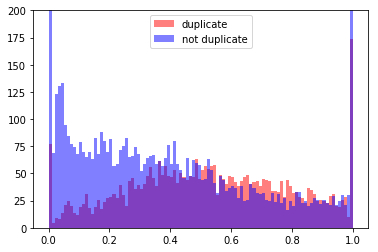

In [98]:
plot_histograms(tfidf_cosines, y_sample, bins=100)
plt.ylim(0, 200)
plt.show()

It's more informative in regions other than former tf-idf score

In [99]:
lengths_info = train.ix[:len(y_sample)-1].apply(get_lengths_info, axis=1).as_matrix()

In [100]:
lengths_info = pd.DataFrame(np.vstack(lengths_info), columns=['l1', 'l2', 'log_l1', 'log_l2', 'avg1', 'avg2',
                                                             'diff avg', 'diff median', 'diff var', 'diff len',
                                                             'diff log len'])

In [101]:
lengths_info.head()

,l1,l2,log_l1,log_l2,avg1,avg2,diff avg,diff median,diff var,diff len,diff log len
0,67.0,58.0,4.204693,4.060443,3.533333,3.538462,0.005128,0.0,0.040657,9.0,0.144250
1,50.0,87.0,3.912023,4.465908,3.636364,4.500000,0.863636,1.0,0.973140,37.0,0.553885
2,74.0,60.0,4.304065,4.094345,4.000000,4.545455,0.545455,0.0,0.358127,14.0,0.209721
3,50.0,45.0,3.912023,3.806662,3.250000,4.625000,1.375000,1.0,1.130208,5.0,0.105361
4,75.0,40.0,4.317488,3.688879,4.428571,4.125000,0.303571,0.5,0.706952,35.0,0.628609


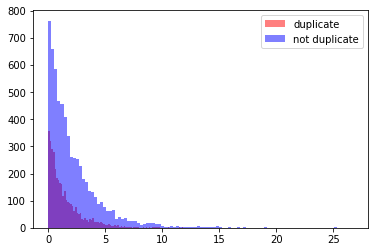

In [102]:
plot_histograms(lengths_info['diff var'].as_matrix(), y_sample, bins=100)
plt.show()

In [103]:
raw_train = pd.read_csv('train.csv')

In [104]:
punct_info = raw_train.ix[:len(y_sample)-1].apply(get_specific_info, axis=1).as_matrix()

In [105]:
punct_df = pd.DataFrame(np.vstack(punct_info), columns=['math', 'question 1', 'question 2', 'non ascii 1', 'non ascii 2'])

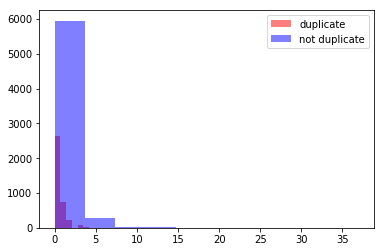

In [106]:
plot_histograms(np.abs(punct_df['non ascii 1']-punct_df['non ascii 2']), y_sample)
plt.show()

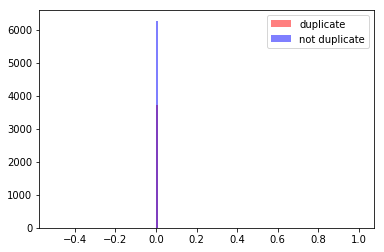

In [107]:
plot_histograms(punct_df['math'], y_sample, bins=100)
plt.show()

In [108]:
np.where(raw_train.ix[:len(y_sample)].apply(lambda x: 1 if '[math]' in x['question1'] and '[math]' in x['question2'] else 0, axis=1).as_matrix())

(array([ 362,  764, 1275, 2712, 3762, 7466, 8663]),)

In [109]:
raw_train.ix[764, ['question1', 'question2']].tolist()

['What is [math]x[/math] if [math]x+\\left(\\dfrac{1}{x}\\right) =0[/math]?',
 'What is [math]\\mathop {\\lim}\\limits_{x \\to 0^+}\\frac{1}{x}^\\frac{-x}{x+1}[/math]?']

In [110]:
d = raw_train.ix[:len(y_sample)].apply(lambda x: '[math]' in x['question1'], axis=1)

In [111]:
unioned_new_scores = np.concatenate([unioned, tfidf_cosines.reshape(-1, 1)], axis=1)

In [112]:
x_train, x_test, y_train, y_test = train_test_split(unioned_new_scores, np.asarray(y_sample), test_size=.3)

In [113]:
lr = LogisticRegression(C=5)
lr.fit(x_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
cross_val_score(lr, unioned_new_scores, y_sample, scoring='neg_log_loss', cv=10).mean()

-0.54188574109848209

In [115]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly_with_new = poly.fit_transform(unioned_new_scores)

In [116]:
cross_val_score(lr, poly_with_new, y_sample, scoring='neg_log_loss', cv=10).mean()

-0.53259007622011567

In [117]:
redundant_feats = merge_features(unioned_new_scores, lengths_info.ix[:, 4:].as_matrix())

In [118]:
cross_val_score(lr, redundant_feats, y_sample, scoring='neg_log_loss', cv=10).mean()

-0.53929218792506506

In [119]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly_with_redund = poly.fit_transform(redundant_feats)

In [120]:
cross_val_score(lr, poly_with_redund, y_sample, scoring='neg_log_loss', cv=10).mean()

-0.5352398344889957

In [121]:
import xgboost as xgb

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [126]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

#shameless theft from anokas' notebook, since I have precisely zero knowledge about tuning XGB

In [132]:
fin_x_train, fin_x_test, fin_y_train, fin_y_test = train_test_split(unioned_new_scores, y_sample)

d_train = xgb.DMatrix(fin_x_train, label=fin_y_train)
d_valid = xgb.DMatrix(fin_x_test, label=fin_y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68815	valid-logloss:0.688512
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.647126	valid-logloss:0.64979
[20]	train-logloss:0.617844	valid-logloss:0.622442
[30]	train-logloss:0.59621	valid-logloss:0.602449
[40]	train-logloss:0.579806	valid-logloss:0.587497
[50]	train-logloss:0.567078	valid-logloss:0.575945
[60]	train-logloss:0.556985	valid-logloss:0.567034
[70]	train-logloss:0.548988	valid-logloss:0.56029
[80]	train-logloss:0.542644	valid-logloss:0.554706
[90]	train-logloss:0.537435	valid-logloss:0.55028
[100]	train-logloss:0.532803	valid-logloss:0.546767
[110]	train-logloss:0.528946	valid-logloss:0.543968
[120]	train-logloss:0.525693	valid-logloss:0.541574
[130]	train-logloss:0.522934	valid-logloss:0.539711
[140]	train-logloss:0.520538	valid-logloss:0.538157
[150]	train-logloss:0.518323	valid-logloss:0.536998
[160]	train-logloss:0.516589	vali